## Note:
- 'kinematic-corrections.py' from commit 'fead868' of https://github.com/kateharborne/kinematic_corrections is used for this code.
- 'mg_lambdaR_e_calc.py' from commit '0774f16' of https://github.com/marktgraham/lambdaR_e_calc is used for this code
- 07/16/2021: Update on how to run this example. There was an error on how to update submodule
- 09/03/2021: Add H20 correction curve using circularisd radii definition. Plot curves for all n_sersic cases (n=1,2,3,4) together.

## How to run this example:

- git clone https://github.com/astrohchung/spin_correction_test
- (enter the directory)
- cd spin_correction_test
- git submodule init
- git submodule update
- (change the permission of './kinematic_corrections/kinematic-corrections.py' file to executable.)
- cd kinematic_corrections
- chmod 777 kinematic-corrections.py
- cd ..
- cp ./lambdaR_e_calc/mg_lambdaR_e_calc.py g18corr.py
- open g18corr.py and commenting out line 5: 'from cap_display_pixels import display_pixels'

- open and run spin_correction_test.ipynb


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import system
from g18corr import lambdaR_e_correct


# Generate data points for Harborne2020 correction

In [2]:
#correction function manually quoted from Harborne2020 (for elr, not lr)
#equation (18) and (A1) from Harborne2020
def f_por(por):
    return (7.49/(1+np.exp(4.01*por**1.57+2.84))-0.41)

def f_e_n_rfac(e,n,rfac):
    return (0.02*np.log10(e)-0.19*np.log10(n)-0.13*rfac+0.28)

def dl_corr(por, e, n, rfac):
    return (f_por(por)+por*f_e_n_rfac(e,n,rfac))

#when psf_over_re=0.45, n=1, e=1, rfac=1
psf_over_re_check=0.45
n_plot=1
e=1
rfac=1
lr_obs_over_lr_corr=1/10**(-dl_corr(psf_over_re_check, e, n_plot, rfac))
print(psf_over_re_check, lr_obs_over_lr_corr)


0.45 0.6226687931537687


In [3]:
def generate_h20_corr_data(ndata=50, e=1, n=1, Reff_fac=1, filename='test_input.csv'):
    ndata=50
    psf_over_re=np.arange(ndata)/ndata*0.4+0.1
    obs_lr=np.ones(ndata)
    obs_elr=np.ones(ndata)
    # e=np.ones(ndata)*0.001
    e_in=np.ones(ndata)*e
    n_in=np.ones(ndata)*n
    Reff_fac_in=np.ones(ndata)*Reff_fac
    # Re=np.ones(ndata)*1

    test_df=pd.DataFrame(
        {
            'psf_over_re':psf_over_re,
            'obs_lr':obs_lr,
            'obs_elr':obs_elr,
            'e':e_in,
            'n':n_in,
            'Reff_fac':Reff_fac_in,
    #         'Re':Re,
    #         'fwhm':fwhm,
        }
    )
    test_df.to_csv(filename)

In [4]:
#generate n=1-4, e=1, data
for nplot in np.arange(4)+1:
    nstr=str(nplot)
    sample_data_filename='sample_input_n'+nstr+'_e1.csv'
    generate_h20_corr_data(ndata=50, e=1, n=nplot, Reff_fac=1, filename=sample_data_filename)
    sample_data_corr_filename='sample_output_n'+nstr+'_e1.csv'

    dqt='"'
    cmd='./kinematic_corrections/kinematic-corrections.py'+' -i '+dqt+sample_data_filename+dqt+' -o '+dqt+sample_data_corr_filename+dqt
    print(cmd)
    system(cmd)

    #generate n=1, e=0.01, data
    sample_data_filename='sample_input_n'+nstr+'_e001.csv'
    generate_h20_corr_data(ndata=50, e=0.01, n=nplot, Reff_fac=1, filename=sample_data_filename)
    sample_data_corr_filename='sample_output_n'+nstr+'_e001.csv'

    dqt='"'
    cmd='./kinematic_corrections/kinematic-corrections.py'+' -i '+dqt+sample_data_filename+dqt+' -o '+dqt+sample_data_corr_filename+dqt
    print(cmd)
    system(cmd)


./kinematic_corrections/kinematic-corrections.py -i "sample_input_n1_e1.csv" -o "sample_output_n1_e1.csv"
./kinematic_corrections/kinematic-corrections.py -i "sample_input_n1_e001.csv" -o "sample_output_n1_e001.csv"
./kinematic_corrections/kinematic-corrections.py -i "sample_input_n2_e1.csv" -o "sample_output_n2_e1.csv"
./kinematic_corrections/kinematic-corrections.py -i "sample_input_n2_e001.csv" -o "sample_output_n2_e001.csv"
./kinematic_corrections/kinematic-corrections.py -i "sample_input_n3_e1.csv" -o "sample_output_n3_e1.csv"
./kinematic_corrections/kinematic-corrections.py -i "sample_input_n3_e001.csv" -o "sample_output_n3_e001.csv"
./kinematic_corrections/kinematic-corrections.py -i "sample_input_n4_e1.csv" -o "sample_output_n4_e1.csv"
./kinematic_corrections/kinematic-corrections.py -i "sample_input_n4_e001.csv" -o "sample_output_n4_e001.csv"


In [5]:

# df_n1_e1=pd.read_csv('sample_output_n1_e1.csv')
# df_n1_e001=pd.read_csv('sample_output_n1_e001.csv')

# corr_elr_n1_e1=df_n1_e1['corr_elr']
# corr_elr_n1_e001=df_n1_e001['corr_elr']

# corr_lr_n1_e1=df_n1_e1['corr_lr']
# corr_lr_n1_e001=df_n1_e001['corr_lr']

# psf_over_re=df_elr_n1_e001['psf_over_re']


# Reconstruct the left most panel of Chung2021 deconvolution paper Figure 14

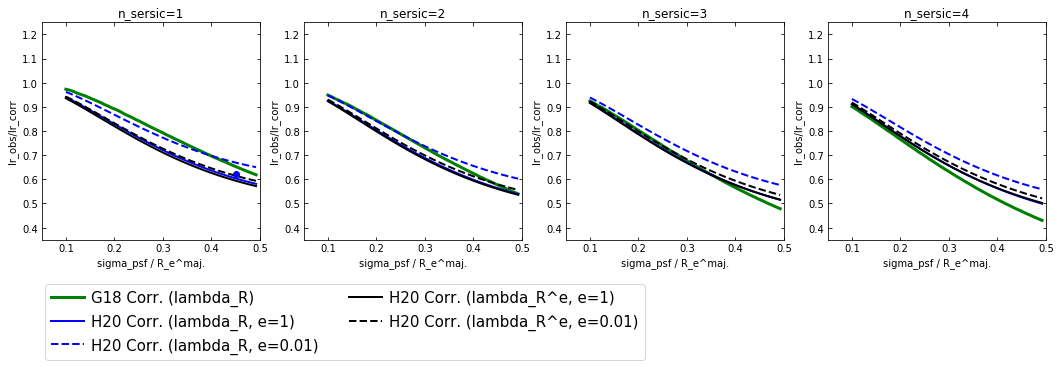

In [6]:
fig=plt.figure(figsize=(18,4))


# for nplot in np.arange(4)+1:
for nplot in np.arange(4)+1:
    ax=fig.add_subplot(1,4,nplot)
    nstr=str(nplot)

    df_n_e1=pd.read_csv('sample_output_n'+nstr+'_e1.csv')
    df_n_e001=pd.read_csv('sample_output_n'+nstr+'_e001.csv')

    corr_elr_n_e1=df_n_e1['corr_elr']
    corr_elr_n_e001=df_n_e001['corr_elr']

    corr_lr_n_e1=df_n_e1['corr_lr']
    corr_lr_n_e001=df_n_e001['corr_lr']

    psf_over_re=df_n_e001['psf_over_re']


    #generate data points for Graham2018 correction
    # g18corr.py: 
    # def lambdaR_e_correct(lam_obs, semi_maj_axis, sig_psf, n, plot=False):

    ndata=50
    lam_obs=np.ones(ndata)*0.5  #use 0.5, because g18corr.py does not allow lam_obs>=1
    semi_maj_axis=np.ones(ndata)
    sig_psf=np.arange(ndata)/ndata*0.4+0.1
    n=np.ones(ndata)*nplot

    lam_corr, _ , _, =lambdaR_e_correct(lam_obs, semi_maj_axis, sig_psf, n)

    ratio_g18_n=lam_obs/lam_corr





    ratio_elr_n_e1=1/corr_elr_n_e1
    ratio_elr_n_e001=1/corr_elr_n_e001

    ratio_lr_n_e1=1/corr_lr_n_e1
    ratio_lr_n_e001=1/corr_lr_n_e001

    lw=2
    
    labels=[
        'G18 Corr. (lambda_R)',
        'H20 Corr. (lambda_R, e=1)',
        'H20 Corr. (lambda_R, e=0.01)',
        'H20 Corr. (lambda_R^e, e=1)',
        'H20 Corr. (lambda_R^e, e=0.01)',
           ]
    
    ax.plot(psf_over_re, ratio_g18_n, color='g', lw=3, linestyle='-', label=labels[0])

    ax.plot(psf_over_re, ratio_lr_n_e001, color='b', lw=lw, linestyle='-', label=labels[1])
    ax.plot(psf_over_re, ratio_lr_n_e1, color='b', lw=lw, linestyle='--', label=labels[2])
    
    ax.plot(psf_over_re, ratio_elr_n_e001, color='k', lw=lw, linestyle='-', label=labels[3])
    ax.plot(psf_over_re, ratio_elr_n_e1, color='k', lw=lw, linestyle='--', label=labels[4])

    if nplot==1:
        ax.plot([psf_over_re_check],[lr_obs_over_lr_corr], 'bo')



    xr=[0.05,0.5]
    yr=[0.35,1.25]
    ax.set_xlim(xr)
    ax.set_ylim(yr)
    ax.set_title('n_sersic='+str(nplot))
    ax.set_xlabel('sigma_psf / R_e^maj.')
    ax.set_ylabel('lr_obs/lr_corr')

    ax.tick_params(axis='both', which='both', direction='in', left=True, right=True, top=True, bottom=True)
    
    if nplot==1:
        leg=ax.legend(
            fontsize=15, handletextpad=0.5, ncol=2,
              handlelength=2.2,
              framealpha=0.8,
              loc='upper left',
              bbox_to_anchor=(-0.02 , -0.17))
#the difference between the dahsed line and blue dot is due to the difference in constants of correction function used. 
#The paper has two significant digits for the correction coefficient. 
#The correction function uploaded on GitHub contains more significant digits.  
#see https://github.com/kateharborne/kinematic_corrections/blob/master/kinematic-corrections.py